# How many tiled MatMul do we need?
Given that matmul is our limiting operation, how many tiled matmul do we need to process a Bert layer?

Assumptions:
- Adding partial sum matrices is free
- Adding bias from linear layers is free
- Moving data to the input of the tiled matmul is fully overlapped with computation (probably realistic with pingpong buffers) 

In [59]:
import math

class MatrixMultiplier:
    def __init__(self, tile, cycles_per_tile, clock_freq):
        self.tile = tile
        self.cycles_per_tile = cycles_per_tile
        self.clock_freq = clock_freq
        
        self.total_tiled_muls = 0
        self.total_cycles = 0
        
    def mul(self, a, b):
        M = a.size()[-2]
        K = a.size()[-1]
        N = b.size()[-1]
        assert b.size()[-2] == K, f'a size {a.size()} b size {b.size()}'
        
        M_blocks = math.ceil(M / self.tile)
        K_blocks = math.ceil(K / self.tile)
        N_blocks = math.ceil(N / self.tile)
        
        n_tiled_mul = M_blocks * K_blocks * N_blocks
        
        self.total_tiled_muls += n_tiled_mul
        self.total_cycles += n_tiled_mul*self.cycles_per_tile
        
        return torch.matmul(a, b)
        
    def summary(self):
        print('-'*10)
        print(f'Using {self.tile}x{self.tile} tiled matrix multiplication:')
        print(f'{self.total_tiled_muls} tiled matmul in total')
        print(f'{self.total_cycles} total cycles')
        print(f'{self.total_cycles / self.clock_freq} seconds of latency at {self.clock_freq/1e6} MHz')
        print(f'{self.clock_freq / self.total_cycles} FPS layer throughput')
        print('-'*10)
        

In [25]:
layer.attention.self.query.weight.data.shape

torch.Size([768, 768])

In [45]:
def attention(mm, layer, hidden_states):
    '''
    hidden_states: <bs, seqlen, dmodel>
    '''
    bs, seqlen, dmodel = hidden_states.size()
    num_heads = layer.attention.self.num_attention_heads
    dhead = layer.attention.self.attention_head_size
    
    # Linear transform to get multiple heads. This is a major MAC slurper.
#     query_layer = layer.attention.self.query(hidden_states) # <bs, seqlen, dmodel>
    query_layer = mm.mul(hidden_states, layer.attention.self.query.weight.data.T)
#     key_layer = layer.attention.self.key(hidden_states)     # <bs, seqlen, dmodel>
    key_layer = mm.mul(hidden_states, layer.attention.self.key.weight.data.T)
#     value_layer = layer.attention.self.value(hidden_states) # <bs, seqlen, dmodel
    value_layer = mm.mul(hidden_states, layer.attention.self.value.weight.data.T)
    
    # Reshape and transpose for multi-head
    new_shape = (bs, seqlen, num_heads, dhead)
    
    query_layer = query_layer.view(new_shape)
    key_layer = key_layer.view(new_shape)
    value_layer = value_layer.view(new_shape)
    
    query_layer = query_layer.permute(0,2,1,3) # <bs, num_head, seqlen, dhead>
    key_layer = key_layer.permute(0,2,3,1)     # <bs, num_head, dhead, seqlen>
    value_layer = value_layer.permute(0,2,1,3) # <bs, num_head, seqlen, dhead>
    
    # The attention main course
    attention_scores = mm.mul(query_layer, key_layer)
    attention_scores /= math.sqrt(dhead)
    
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)
    attention_probs = layer.attention.self.dropout(attention_probs)
    
    attention_out = mm.mul(attention_probs, value_layer)
    
    attention_out = attention_out.permute(0,2,1,3).contiguous()
    attention_out = attention_out.view(bs, seqlen, dmodel)
    
    # It's time for one more linear transform and layer norm
    dense_out = mm.mul(attention_out, layer.attention.output.dense.weight.data.T)
    dense_out = layer.attention.output.dropout(dense_out)
    # Implements the residual connection
    layer_out = layer.attention.output.LayerNorm(dense_out + hidden_states)
    
    return layer_out

def ffn(mm, layer, attention_out):
    
    # Layer 1
    output = mm.mul(attention_out, layer.intermediate.dense.weight.data.T)
    output = nn.functional.gelu(output)
    
    # Layer 2
    output = mm.mul(output, layer.output.dense.weight.data.T)
    output = layer.output.dropout(output)
    output = layer.output.LayerNorm(output + attention_out)
    
    return output

In [32]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
model = BertModel.from_pretrained('bert-base-uncased')
layer = model.encoder.layer[0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [62]:
def measure(mm):
    fake_in = torch.zeros(1, 512, 768)
    attn_out = attention(mm, layer, fake_in)
    ffn_out = ffn(mm, layer, attn_out)
    mm.summary()

In [65]:
mm16 = MatrixMultiplier(tile=16, cycles_per_tile=21, clock_freq=300e6)
measure(mm16)

----------
Using 16x16 tiled matrix multiplication:
892928 tiled matmul in total
18751488 total cycles
0.06250496 seconds of latency at 300.0 MHz
15.998730340760158 FPS layer throughput
----------


In [66]:
mm32 = MatrixMultiplier(tile=32, cycles_per_tile=(32+15), clock_freq=300e6)
measure(mm32)

----------
Using 32x32 tiled matrix multiplication:
111616 tiled matmul in total
5245952 total cycles
0.017486506666666665 seconds of latency at 300.0 MHz
57.18695100527035 FPS layer throughput
----------


In [67]:
mm64 = MatrixMultiplier(tile=64, cycles_per_tile=(64+31), clock_freq=300e6)
measure(mm64)

----------
Using 64x64 tiled matrix multiplication:
13952 tiled matmul in total
1325440 total cycles
0.0044181333333333335 seconds of latency at 300.0 MHz
226.33993239980686 FPS layer throughput
----------


In [68]:
mm128 = MatrixMultiplier(tile=128, cycles_per_tile=(128+63), clock_freq=300e6)
measure(mm128)

----------
Using 128x128 tiled matrix multiplication:
1760 tiled matmul in total
336160 total cycles
0.0011205333333333333 seconds of latency at 300.0 MHz
892.4321751546883 FPS layer throughput
----------


# 4 Stage Pipeline

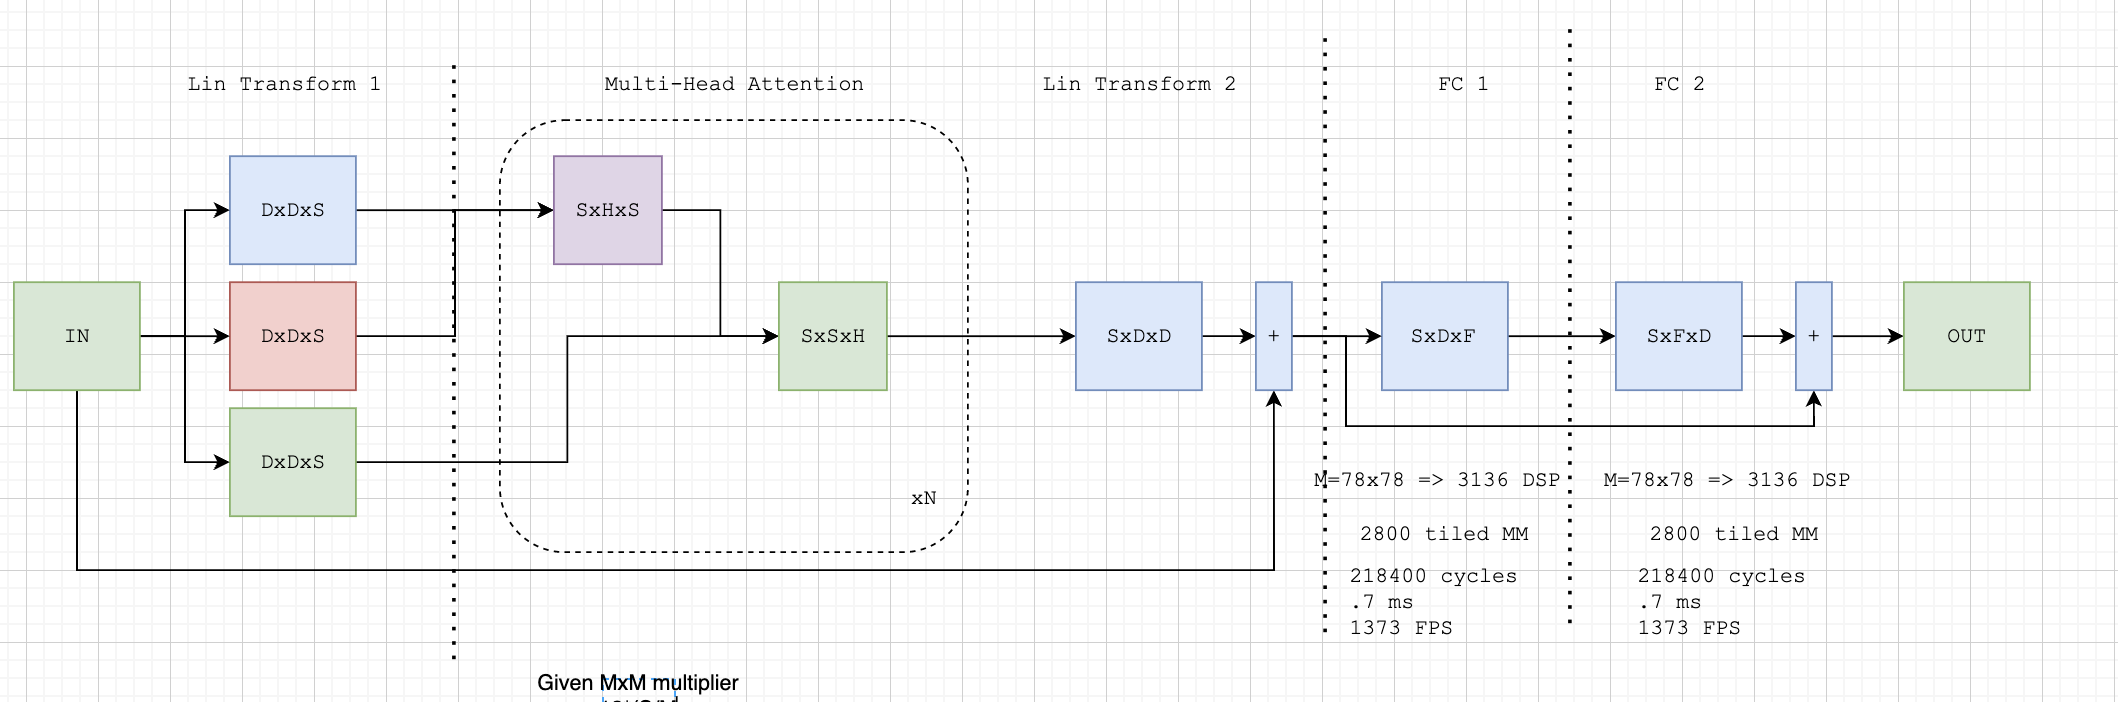

In [58]:
D = 768
S = 512
H = 64
N = 12
F = 3072

DSP = 6840
PE = DSP*2
import math
import numpy as np
import matplotlib.pyplot as plt

We can afford up to 82 tile size with 6840 PEs in stage 3.
77x77 PEs gives the most bang for buck: 215600.0 cycles
DSP Utilization: 5929
BRAM Utilization: 9.043968 MB


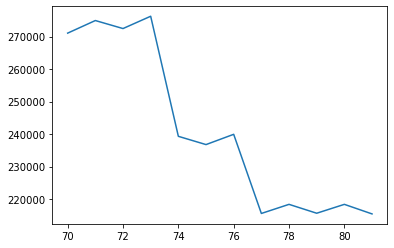

In [129]:
'''
Stage 3 and 4 tile design
'''
M3 = np.arange(70, 82)
stage3_mm = np.ceil(S/M3)*np.ceil(D/M3)*np.ceil(F/M3)
stage3_cycles = stage3_mm * M3
plt.plot(M3, stage3_cycles)

print(f'We can afford up to {math.floor((PE/2)**.5)} tile size with {PE//2} PEs in stage 3.')
print(f'77x77 PEs gives the most bang for buck: {stage3_cycles[M3==77][0]} cycles')
print(f'DSP Utilization: {2*(77**2)//2}')
print(f'BRAM Utilization: {(S*D*2+D*F+S*F+S*F+F*D+S*D)/1e6} MB')

In [100]:
'''
Stage 2 design: match 
'''
M2 =  np.arange(50, 80)
stage2_mm = N*(np.ceil(S/M2)**2*np.ceil(H/M2)*2) + np.ceil(S/M2)*np.ceil(D/M2)**2
stage2_cycles = stage2_mm * M2
stage2_cycles

array([431200., 439824., 366600., 373650., 380700., 371800., 378560.,
       322164., 327816., 333468., 324540., 329949., 335358., 340767.,
       172032., 174720., 177408., 180096., 182784., 185472., 175280.,
       177784., 180288., 182792., 149702., 151725., 153748., 144452.,
       146328., 148204.])

In [99]:
M1 = np.arange(50, 80)
stage1_mm = 3*np.ceil(D/M1)**2*np.ceil(S/M1)
stage1_cycles = stage1_mm * M1
stage1_cycles

array([422400., 430848., 351000., 357750., 364500., 323400., 329280.,
       301644., 306936., 312228., 273780., 278343., 282906., 287469.,
       221184., 224640., 228096., 231552., 235008., 238464., 203280.,
       206184., 209088., 211992., 188034., 190575., 193116., 161700.,
       163800., 165900.])

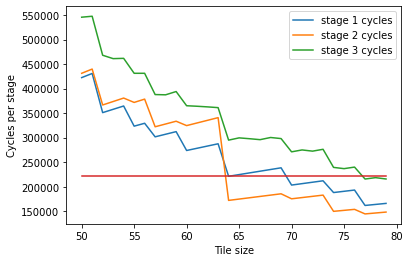

In [101]:
plt.plot(M1, stage1_cycles, label='stage 1 cycles')
plt.plot(M2, stage2_cycles, label='stage 2 cycles')
plt.plot(M3, stage3_cycles, label='stage 3 cycles')
plt.xlabel('Tile size')
plt.ylabel('Cycles per stage')
plt.plot(M1, np.ones_like(M1)*221184.0)
plt.legend()

In [108]:
stage3_cycles[M3 == 74]

array([239316.])

In [109]:
300e6 / 239316

1253.5726821441108

In [110]:
74*74/2

2738.0